In [1]:
import pandas as pd  
import numpy as np

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch.utils.data as data_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

plt.rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["N", "Y"]

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('/Users/wbchoi/PycharmProjects/ai_projects/C_ITS/prediction_modeling/full_data_kma_hours_lightgbm_feature_extract.csv')

In [4]:
df.head()

,SUB_YN,ROAD_TYPE,REST_VEH,MAX_SPD,LANES,CW_YN,BUS_YN,A3_ROADTYPE_1_YN,A1_LANE_04_YN,A1_BARR_03_YN,...,A1_BARR_03_CNT,A1_BARR_02_CNT,topis_22_07,pop_22_07,WS,WD,TEMP,RF,HM,SAGO_YN
0,0,0,0,60.0,5.0,1,1,0,0,0,...,0.0,0.0,0.250954,0.024952,0.064220,0.943889,0.419935,0.0,0.727227,0
1,0,0,0,60.0,5.0,1,1,0,0,0,...,0.0,0.0,0.250954,0.024952,0.146789,0.911667,0.418301,0.0,0.707207,0
2,0,0,0,60.0,5.0,1,1,0,0,0,...,0.0,0.0,0.250954,0.024952,0.100917,0.956667,0.410131,0.0,0.755255,0
3,0,0,0,60.0,5.0,1,1,0,0,0,...,0.0,0.0,0.250954,0.024952,0.100917,0.963611,0.410131,0.0,0.764765,0
4,0,0,0,60.0,5.0,1,1,0,0,0,...,0.0,0.0,0.250954,0.024952,0.128440,0.973333,0.405229,0.0,0.775275,0


In [5]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.SAGO_YN == 0]
X_train = X_train.drop(['SAGO_YN'], axis=1)
print(type(X_train))

y_test = X_test['SAGO_YN']
X_test = X_test.drop(['SAGO_YN'], axis=1)

X_train = X_train.values
print(type(X_train))

X_test = X_test.values
y_test = y_test.values
print(y_test.size)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
3159526


In [6]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        
        super(Autoencoder, self).__init__()
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(36,18),
            nn.Tanh(),
            
            nn.Linear(18,9),
            nn.Tanh()
            )
        
        # latent space
        self.ls = nn.Sequential(
            nn.Linear(9,9),
            nn.Tanh()
            )
        
        # decoder
        self.decoder = nn.Sequential(            
            nn.Linear(9, 18),
            nn.Tanh(),
                        
            nn.Linear(18, 36),
            nn.ReLU()
            )

    def forward(self , x):
        x = self.encoder(x)
        x = self.ls(x)
        x = self.decoder(x)
        return(x)

In [7]:
'''double() : torch.float32'''
# model = Autoencoder().double().cpu()
model = Autoencoder().double()

model = model.to(device)

In [8]:
num_epochs = 30
batch_size = 1024
weight_decay = 10e-8
gamma = 0.1
step_size = 10
lr = 10e-5

In [9]:
train_loader = data_utils.DataLoader(X_train,batch_size=batch_size,shuffle=True, num_workers = 6)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [10]:
criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=gamma, step_size=step_size, last_epoch=-1)

In [11]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [12]:
'''for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    # ===================log========================
    
    # learning rate decay
    scheduler.step()
    
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)'''

epoch [1/30], loss:57.1260
epoch [2/30], loss:16.5844
epoch [3/30], loss:3.5865
epoch [4/30], loss:2.9940
epoch [5/30], loss:2.5503
epoch [6/30], loss:0.4924
epoch [7/30], loss:0.2106
epoch [8/30], loss:0.1079
epoch [9/30], loss:0.0847
epoch [10/30], loss:0.0806
epoch [11/30], loss:0.0790
epoch [12/30], loss:0.0785
epoch [13/30], loss:0.0781
epoch [14/30], loss:0.0778
epoch [15/30], loss:0.0776
epoch [16/30], loss:0.0774
epoch [17/30], loss:0.0773
epoch [18/30], loss:0.0772
epoch [19/30], loss:0.0771
epoch [20/30], loss:0.0770
epoch [21/30], loss:0.0769
epoch [22/30], loss:0.0769
epoch [23/30], loss:0.0769
epoch [24/30], loss:0.0769
epoch [25/30], loss:0.0769
epoch [26/30], loss:0.0769
epoch [27/30], loss:0.0769
epoch [28/30], loss:0.0768
epoch [29/30], loss:0.0768
epoch [30/30], loss:0.0768


In [13]:
'''torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': loss
            }, 'pytorch_AE_model/model_epoch_30.pkl')'''

In [14]:
step_size = 1

In [15]:
model = Autoencoder().double()
model = model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(
    model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=gamma, step_size=step_size, last_epoch=-1)

In [16]:
checkpoint = torch.load('pytorch_AE_model/model_epoch_30.pkl')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [18]:
'''model.train()

for epoch in range(num_epochs):    
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    # ===================log========================
    
    # learning rate decay
    scheduler.step()
    
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)'''

epoch [1/30], loss:0.0768
epoch [2/30], loss:0.0768
epoch [3/30], loss:0.0768
epoch [4/30], loss:0.0768
epoch [5/30], loss:0.0768
epoch [6/30], loss:0.0768
epoch [7/30], loss:0.0768
epoch [8/30], loss:0.0768
epoch [9/30], loss:0.0768
epoch [10/30], loss:0.0768
epoch [11/30], loss:0.0768
epoch [12/30], loss:0.0768
epoch [13/30], loss:0.0768
epoch [14/30], loss:0.0768
epoch [15/30], loss:0.0768
epoch [16/30], loss:0.0768
epoch [17/30], loss:0.0768
epoch [18/30], loss:0.0768
epoch [19/30], loss:0.0768
epoch [20/30], loss:0.0768
epoch [21/30], loss:0.0768
epoch [22/30], loss:0.0768
epoch [23/30], loss:0.0768
epoch [24/30], loss:0.0768
epoch [25/30], loss:0.0768
epoch [26/30], loss:0.0768
epoch [27/30], loss:0.0768
epoch [28/30], loss:0.0768
epoch [29/30], loss:0.0768
epoch [30/30], loss:0.0768


In [19]:
'''torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': loss
            }, 'pytorch_AE_model/model_epoch_60.pkl')'''

In [20]:
model = Autoencoder().double()
model = model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=gamma, step_size=1, last_epoch=-1)

In [21]:
checkpoint = torch.load('pytorch_AE_model/model_epoch_60.pkl')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [23]:
'''plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.axis([0,10,0.0,4.0])
plt.legend(['train', 'test'], loc='upper right');
plt.show()'''

"plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)\nplt.plot(history['train_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\n# plt.axis([0,10,0.0,4.0])\nplt.legend(['train', 'test'], loc='upper right');\nplt.show()"

In [24]:
pred_losses = { 'pred_loss' : []}
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=36, out_features=18, bias=True)
    (1): Tanh()
    (2): Linear(in_features=18, out_features=9, bias=True)
    (3): Tanh()
  )
  (ls): Sequential(
    (0): Linear(in_features=9, out_features=9, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): Tanh()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
  )
)

In [26]:
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
        
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['SAGO_YN'] = y_test

In [27]:
reconstructionErrorDF.head(5)

,pred_loss,SAGO_YN
0,0.741956,0
1,0.075979,0
2,0.076967,0
3,0.045365,0
4,0.743944,0


In [28]:
reconstructionErrorDF['SAGO_YN'].value_counts()

0    3158781
1        745
Name: SAGO_YN, dtype: int64

In [29]:
reconstructionErrorDF.describe()

,pred_loss,SAGO_YN
count,3.159526e+06,3.159526e+06
mean,7.701080e-02,2.357949e-04
std,1.589244e-01,1.535381e-02
min,1.013114e-03,0.000000e+00
25%,1.349047e-02,0.000000e+00
50%,3.852687e-02,0.000000e+00
75%,6.525579e-02,0.000000e+00
max,8.201270e-01,1.000000e+00


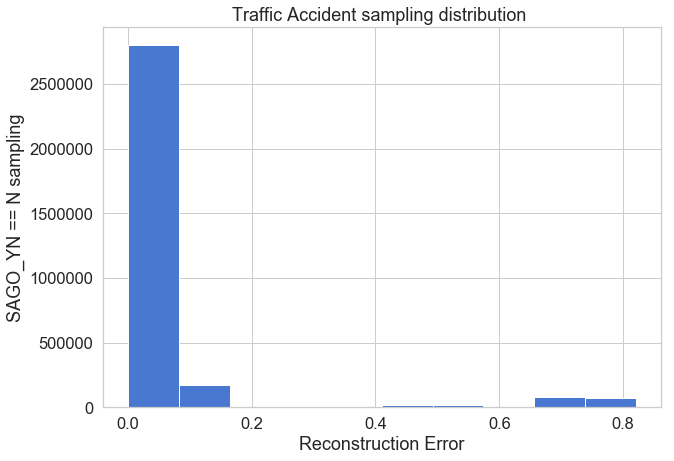

In [147]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = (10, 7)
plt.title('Traffic Accident sampling distribution ')
plt.xlabel('Reconstruction Error')
plt.ylabel('SAGO_YN == N sampling')

ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['SAGO_YN']== 0) & (reconstructionErrorDF['pred_loss'] < 1)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10,color='b')

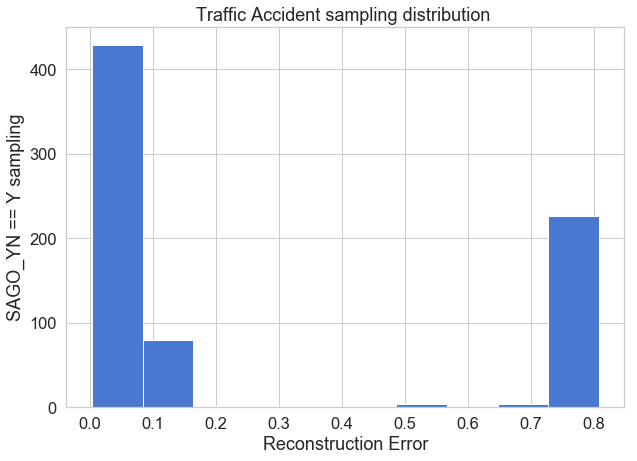

In [143]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Traffic Accident sampling distribution ')
plt.xlabel('Reconstruction Error')
plt.ylabel('SAGO_YN == Y sampling')
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['SAGO_YN']== 1)]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10,color='b')

In [127]:
precision, recall, th = precision_recall_curve(
    reconstructionErrorDF.SAGO_YN, 
    reconstructionErrorDF.pred_loss)

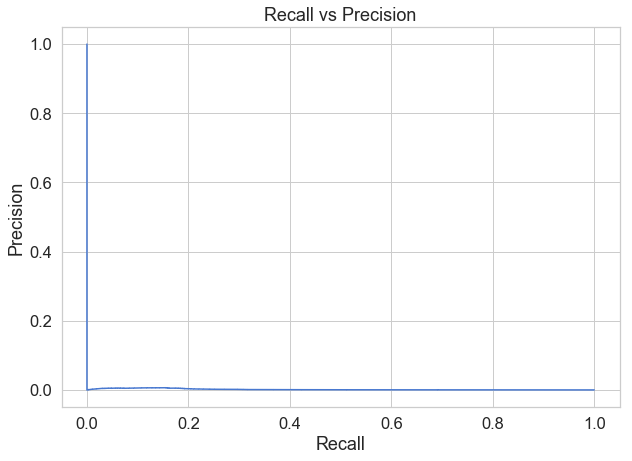

In [128]:
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

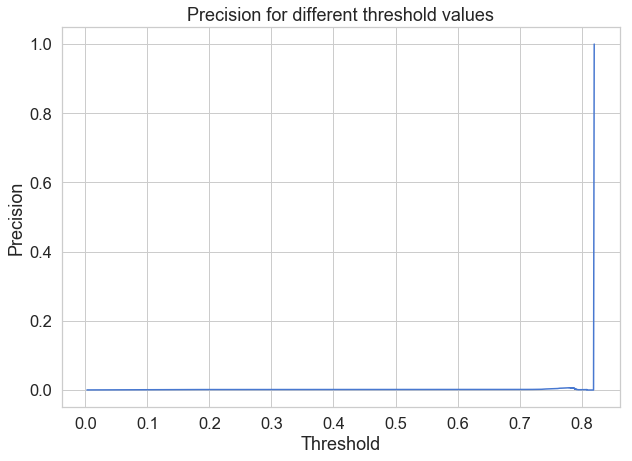

In [129]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

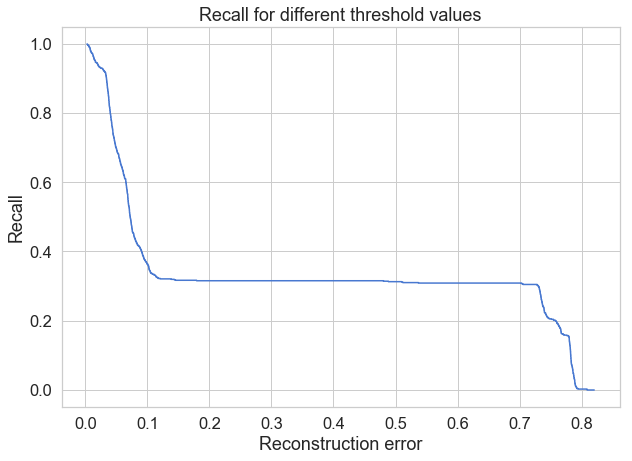

In [130]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

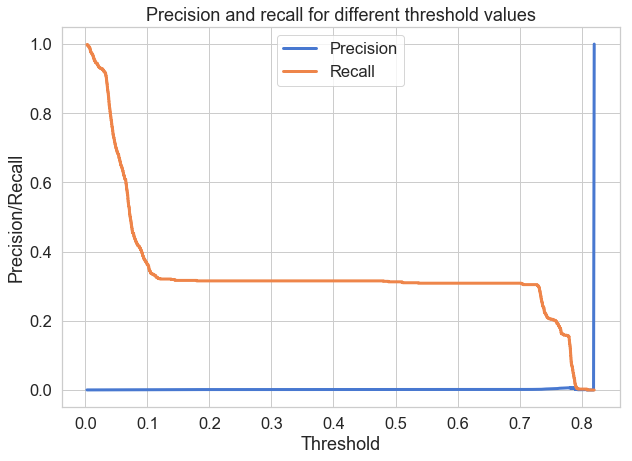

In [140]:
plt.plot(th, precision[1:], label="Precision",linewidth=3)
plt.plot(th, recall[1:], label="Recall",linewidth=3)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

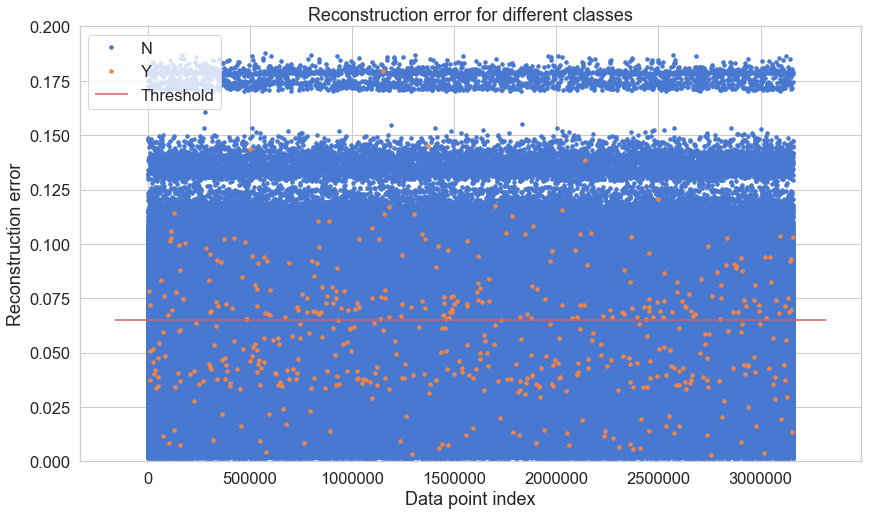

In [132]:
# threshold 이상: 교통사고 Y, threshold 미만: 교통사고 N
threshold = 0.065

groups = reconstructionErrorDF.groupby('SAGO_YN')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
           label= "Y" if name == 1 else "N")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.rcParams['figure.figsize'] = (14, 8)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim(0, 0.2)
plt.show()

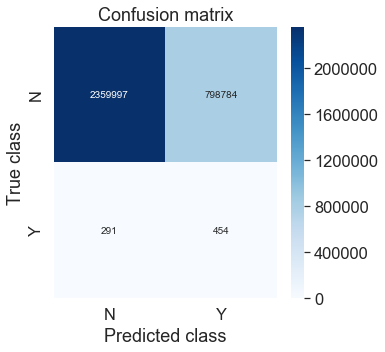

In [133]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.SAGO_YN, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [134]:
csr = classification_report(reconstructionErrorDF.SAGO_YN, y_pred)
print(csr)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86   3158781
           1       0.00      0.61      0.00       745

    accuracy                           0.75   3159526
   macro avg       0.50      0.68      0.43   3159526
weighted avg       1.00      0.75      0.86   3159526



In [135]:
tp = conf_matrix[1,1]
tn = conf_matrix[0,0]
fp = conf_matrix[0,1]
fn = conf_matrix[1,0]

acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp+fp)
rec = tp / (tp+fn)
spec = tn / (fp + tn)

print('정확도 (Accuracy): %f , 정밀도 (Precision): %f , 재현율 (Recall): %f , 특이도 (Specificity): %f' % (acc, prec, rec, spec))

정확도 (Accuracy): 0.747090 , 정밀도 (Precision): 0.000568 , 재현율 (Recall): 0.609396 , 특이도 (Specificity): 0.747123


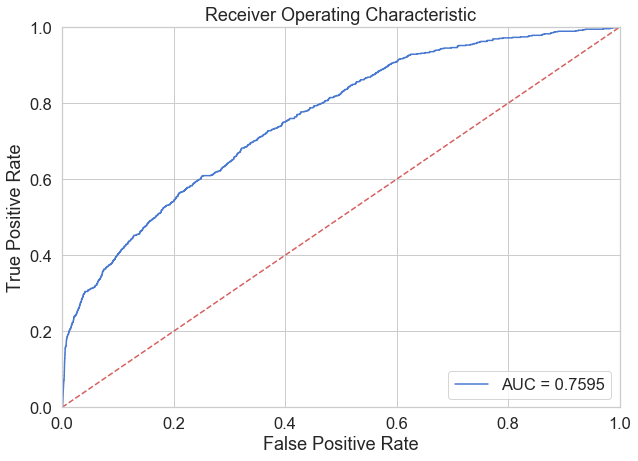

In [138]:
'''pred_loss 나 y_pred 증 기준 필요!!!!!!!!!!!!!!!!!!!'''
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.SAGO_YN, reconstructionErrorDF.pred_loss)
# fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.SAGO_YN, y_pred)

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.rcParams['figure.figsize'] = 10, 7
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();